In [5]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [6]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical linear regression


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical regression

* Hierarchical  regression is  a generalization of linear regression, which allows the  parameters to **vary by group**.


* This allows modelling observations which are  *grouped*  (also referred to as *clustered*). 

# Hierarchical (or multilevel) modeling

A *hierarchical model* provides a compromise between:

* the *pooled model*, which merges the observations from all clusters, fitting a single regression.  This might be  excessively constrained; 


* the *unpooled model*, which fits an independent regression for each cluster. Estimates are however unreliable on cluster containing few observations and there is no generalization to unobserved groups.

# The radon data set (Gelman et al., 2007)

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon data set (Gelman et al., 2007)

* The amount of the radioactive gas radon has been measured among different households in all counties of several states.


* Radon gas is  the highest cause of lung cancer in non-smokers.



* Its level is  generally higher in the basement; moreover, its presence depends on the  type of soil.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota. The state is divided in 85 different *counties*.


* For each measure we know:
    * the county
    * the floor (basement or  first floor) 
    * average  uranium level in the county (positively correlated with radon)

### Data organization

In [7]:
# Import radon data, 919 rows
#Eventually we have log_radon_std (Y), floor_std (X) and the 
#index of the county in which the measurement has been taken.

radon_data = pd.read_csv('data/radon.csv', index_col=0)


#list of  counties in Minnesota (J=85 different counties)
counties      = radon_data.county.unique()
n_counties = counties.shape[0] 

#numerical id of the county of each measure (919 rows)
county               = radon_data.county_code.values
#code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))

#explanatory variable: the floor: 0 (ground level) or 1 (first floor).
#we standardize x to avoid correlation in the posterior.
floor           = radon_data.floor.values
floor_std   = (floor - floor.mean()) / floor.std()

#y 
log_radon         = radon_data.log_radon.values
#standardization of y is useful to set the prior without worrying about the scale of the data.
log_radon_std = (log_radon - log_radon.mean()) / log_radon.std()

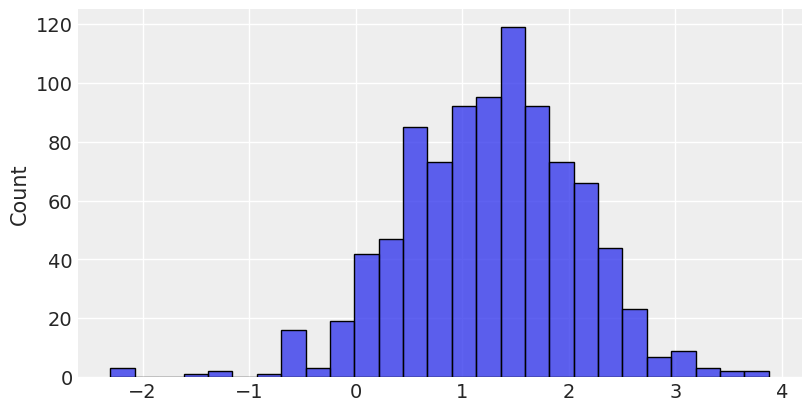

In [8]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

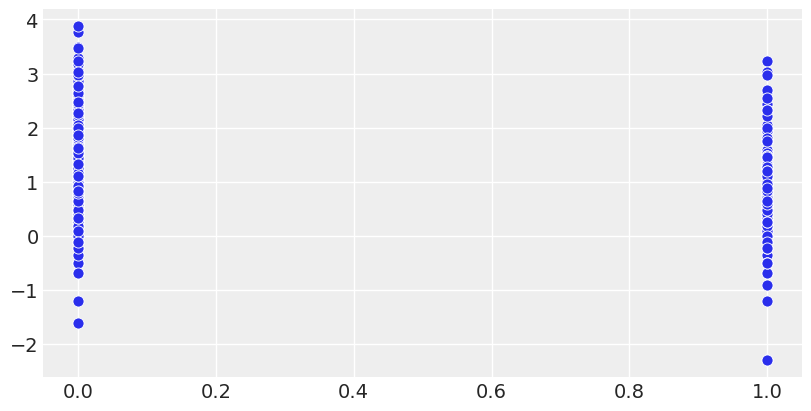

In [7]:
#as floor takes only 0 and 1 as values, we have data organized into two columns 
#The radon level is higher in the basement (floor = 0) than in the first floor (floor = 1).
sns.scatterplot(floor, log_radon);

# Pooled regression

A regression model which ignores the county:

$$y_i \sim N( \alpha + \beta x_i, \sigma)$$


* $y_i$: log-radon measured in the $i$-th household ($i$=1,2,...919)

* $x_i$: floor of the measurement in the $i$-th household (1 or 0; 0 means basement)

* $\alpha$ : intercept.  (on  centered data, it represents the mean log-radon in Minnesota). 


# Pooled regression 

* We have no prior knowledge; we thus use   data-dependent priors. 

* Assuming standardized data ($\sigma_y = 1, \sigma_x =1$), the model is:

\begin{align}
\beta  & \sim N (0,1)  && \text{prior on the slope for standardized data} \\
\alpha &\sim N(0,1) && \text{prior on the intercept for standardized data} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std } \\
y_i  &\sim N( \alpha + \beta x_i,  \sigma) && \text{likelihood}
\end{align}

# Unpooled regression 


$$y_i \sim N( \alpha_{j[i]} + \beta x_i, \sigma) $$

* $\alpha_{j[i]}$ : the intercept for the county where household $i$ is located (think of  $j$ as an array containing the county code for each measure)


*  The intercept is independently estimated of  for each county


# Unpooled regression


$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* The slope $\beta$ is equal for all counties; we assume that the difference between floor and basement does not depend on the county.



# Unpooled model

Assuming standardized data we fit, independently for each of the 85 counties: 

\begin{align}
\beta & \sim N (0,1)  && \text{prior on the slope} \\
\alpha_j &\sim N(0,1) \,\, j=1,2..., 85&& \text{prior on the intercept} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std} \\
y_i  &\sim N( \alpha_{j[i]} + \beta x_i,  \sigma) && \text{likelihood}
\end{align}

# Discussion

* Pooled model: we assume that all observations are samples from the same process,  ignoring the effect of the county.


* Unpooled model: we learn from scratch every model, without transferring any information between models of the different counties.

# Implementation

In [32]:
#pooled model

with pm.Model() as pooled_model:

    alpha = pm.Normal('alpha', mu=0,  sigma=1)
    beta   = pm.Normal('beta', mu=0,  sigma=1)
    sigma = pm.HalfNormal('sigma', 1)
    
    y = pm.Normal('y', alpha + beta*floor_std, sigma, observed=log_radon_std)
    

In [9]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


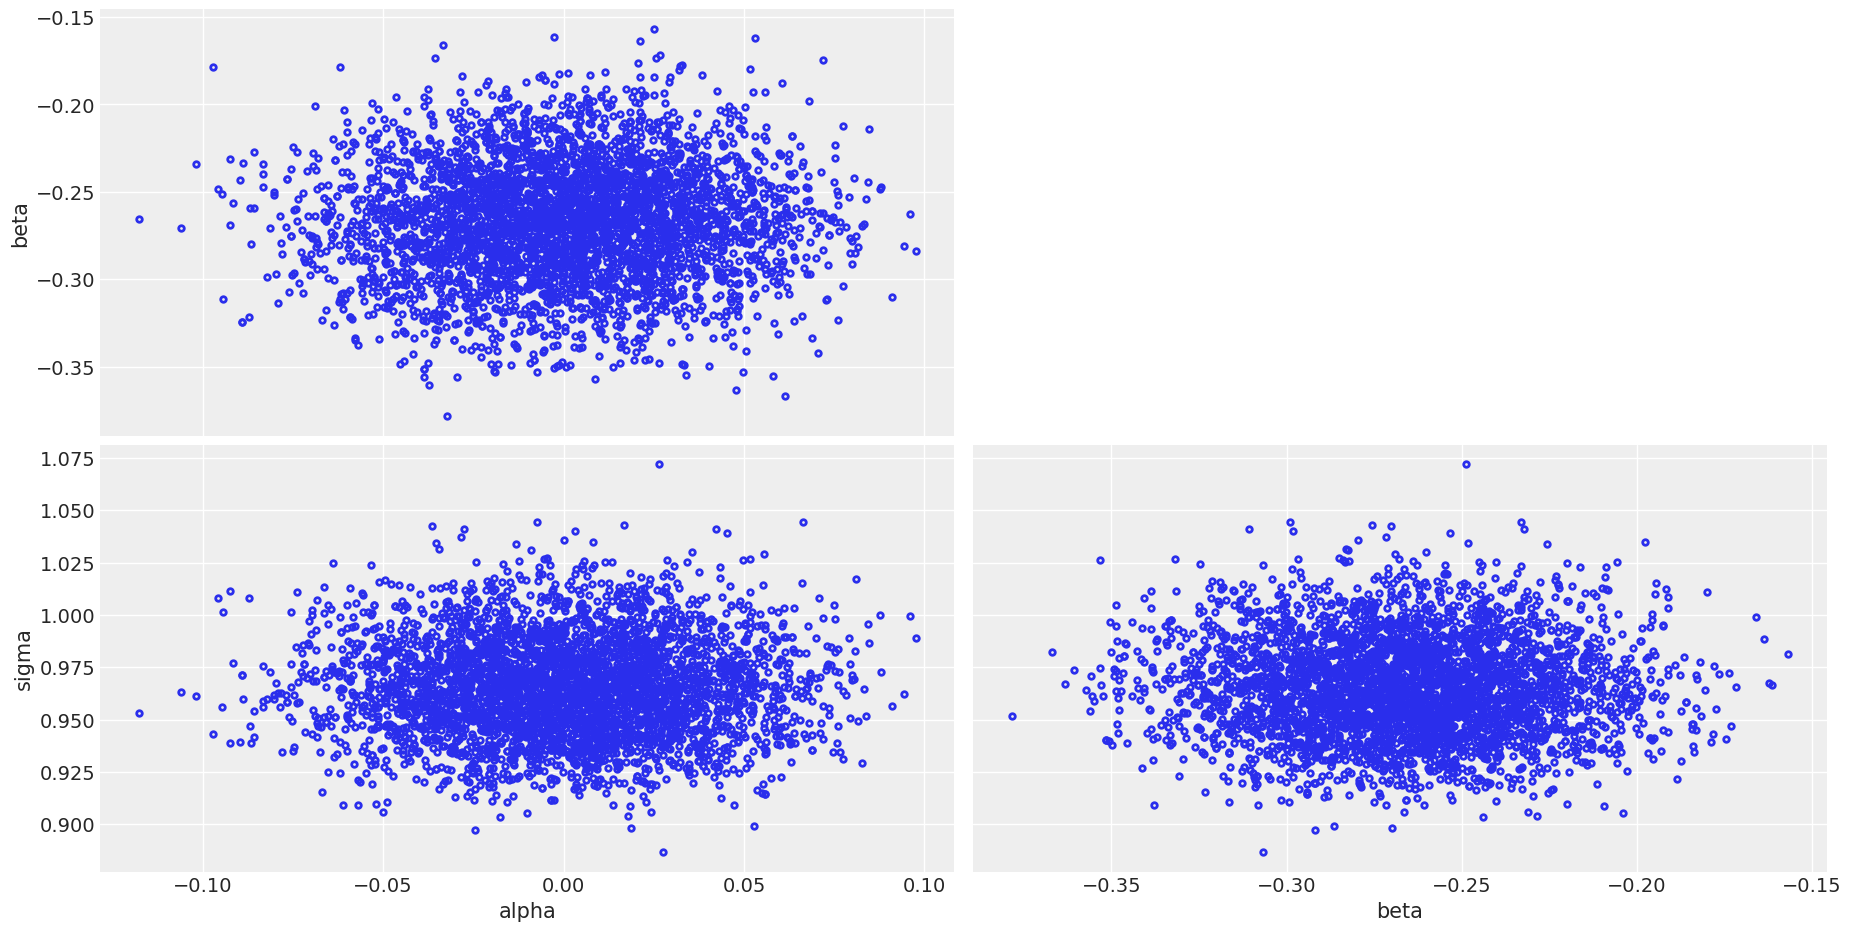

In [10]:
    #standardization of x removes correlation in the posterior.
with pooled_model:
        az.plot_pair(pooled_trace);

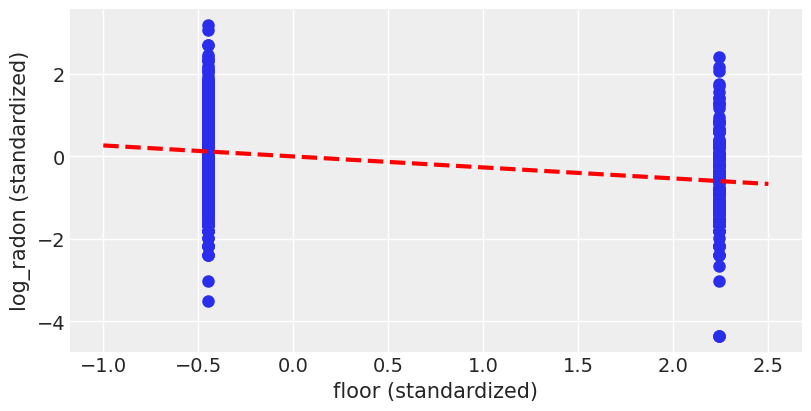

In [21]:
# posterior mean of the parameters
a_pooled =  pooled_trace['alpha'].mean(axis=0)
b_pooled = pooled_trace['beta'].mean(axis=0)

plt.scatter(floor_std, log_radon_std)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('floor (standardized)')
plt.ylabel('log_radon (standardized)');

# Implementation of the unpooled model

In [9]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=n_counties)

    # the slope is the same for all counties
    beta = pm.Normal('beta', mu=0, sigma=1)
    σ   = pm.HalfNormal('σ', 1)
    
    #county is a vector containing the county index  for each measure.
    mu = alpha[county] + beta *floor_std
    
    y = pm.Normal('y', mu, sigma=σ, observed=log_radon_std)
    

In [15]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


## Comparing the pooled and unpooled model

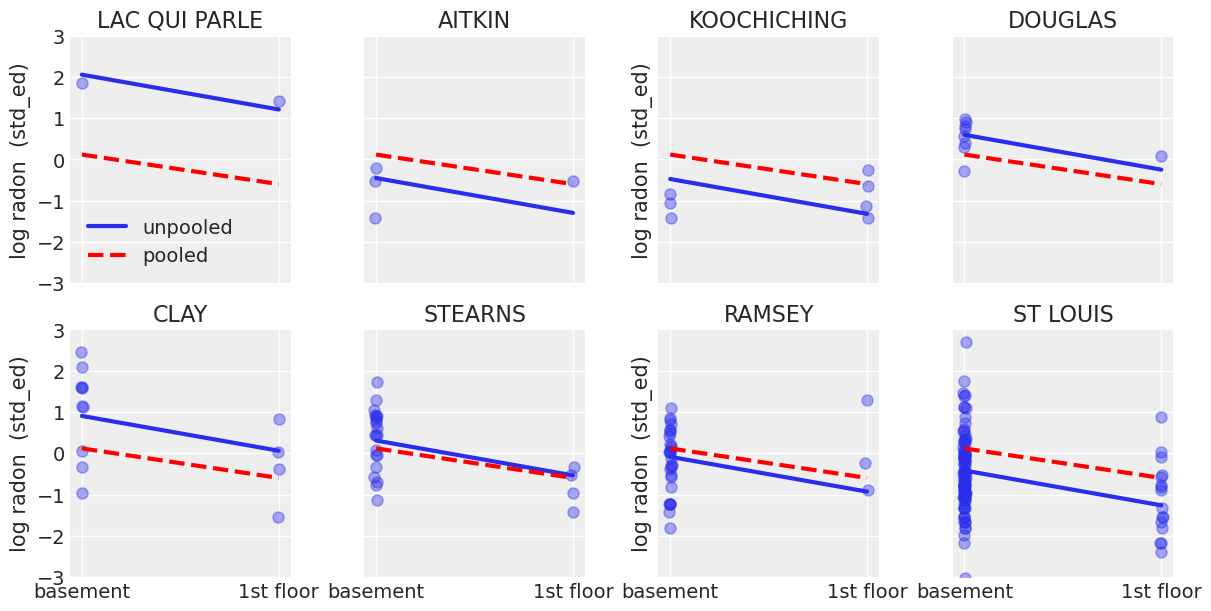

In [60]:
#The code below shows the pooled and unpooled model for some sample counties.
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the unpooled model (posterior mean)
beta_unpooled = unpooled_trace['beta'].mean()
# intercept of the unpooled model (posterior mean): an array, one element for each county.
alpha_unpooled = pd.Series(unpooled_trace['alpha'].mean(axis=0), index=counties)

for i,c in enumerate(sample_counties):
    #select the subset of observation referring to the specific county
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    

    # Plot both models and data
    xvals = np.linspace(floor_std.min(), floor_std.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[c] + beta_unpooled * xvals,  label="unpooled" )
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    axes[i].set_xticks([floor_std.min(), floor_std.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (std_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled.png')

<img src='img/pooled_unpooled.png' width=1000 align="center" >

* The pooled model (red) does not identify high-radon counties
* The unpooled models (blue) yields extreme  estimates in counties where few observations are available,  like LAC QUI PARLE.

# Hierarchical regression


* The hierarchical model  learns:
    * for each county, it uses a different intercept 
    *  it learns  the characteristics of the  population prior from which all these intercepts are samples.

* This a  *varying intercept* model.

* The estimates for  counties with little data are pulled towards that of the pooled model.

# Hierarchical model (varying intercept model)

\begin{align}
y_i  &\sim N( \alpha_{j[i]} + \beta x_i,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,1)  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(0,10)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(5) && \text{prior on the std of intercepts}\\
\end{align}

In [10]:
with pm.Model() as hier_model:
    
    # Population of intercepts
    μ_a = pm.Normal('μ_a', mu=0., sigma=10)
    σ_a = pm.HalfNormal('σ_a', 5)
    
    # Intercepts draw from the population of intercepts
    alpha = pm.Normal('alpha', mu=μ_a, sigma=σ_a, shape=n_counties)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma=1)

    # Expected value
    y_hat = alpha[county] + beta * floor_std
    
    # Std dev control how much the observation deviated from the expected regression line
    σ_y = pm.HalfCauchy('σ_y',1)
    
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon_std)    

In [52]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_y, beta, alpha, σ_a, μ_a]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


## Partial pooling 

* The estimate of the hierarchical model is a compromise, based on sample size, between the pooled and unpooled model  (*partial pooling*):


$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

* Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

* Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

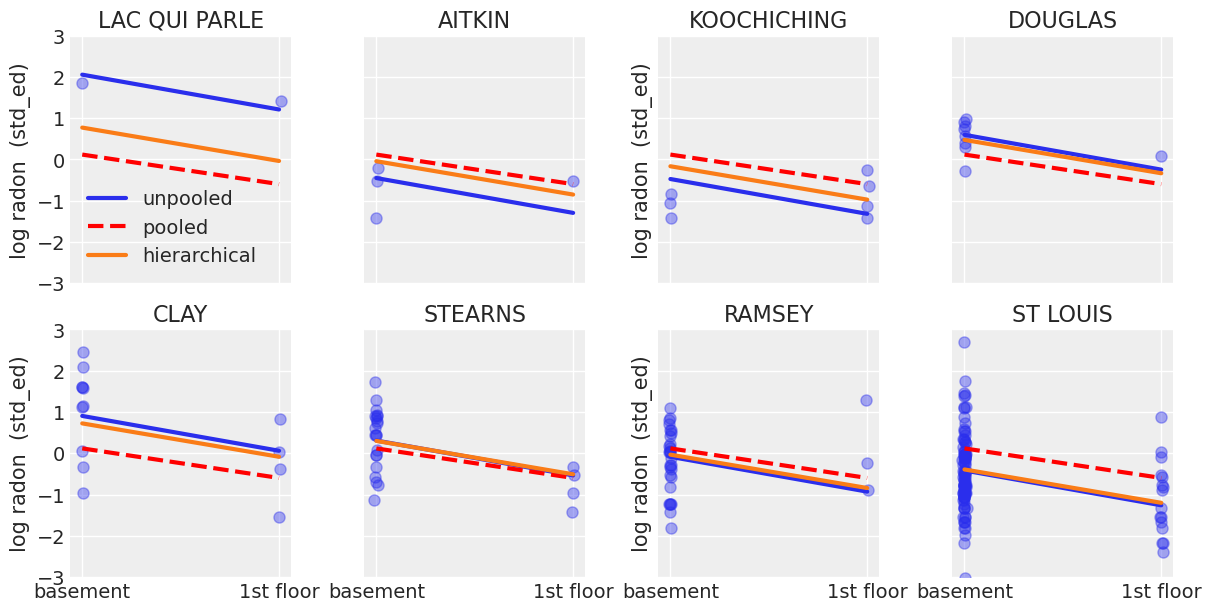

In [66]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#slope of the hier model (posterior mean)
beta_hier = hier_trace['beta'].mean()
# intercept of the hier model (posterior mean): an array, one element for each county.
alpha_hier = pd.Series(hier_trace['alpha'].mean(axis=0), index=counties)


for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(floor_std.min(), floor_std.max() )
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[county_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[county_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    #axes[i].plot(xvals, mp*xvals+ beta_hier[county_lookup[c]], 'k:')
    
    axes[i].set_xticks([floor_std.min(), floor_std.max()])
    axes[i].set_xticklabels(['basement', '1st floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('log radon  (std_ed)')
    axes[0].legend()

plt.savefig('img/pooled_unpooled_hier.png') 

#  The hierarchical model is a sensible compromise 

<img src='img/pooled_unpooled_hier.png' width=900 align="center" >

* On data-rich counties, it close to the unpooled model.

* On data-poor counties, it is close to the pooled model.

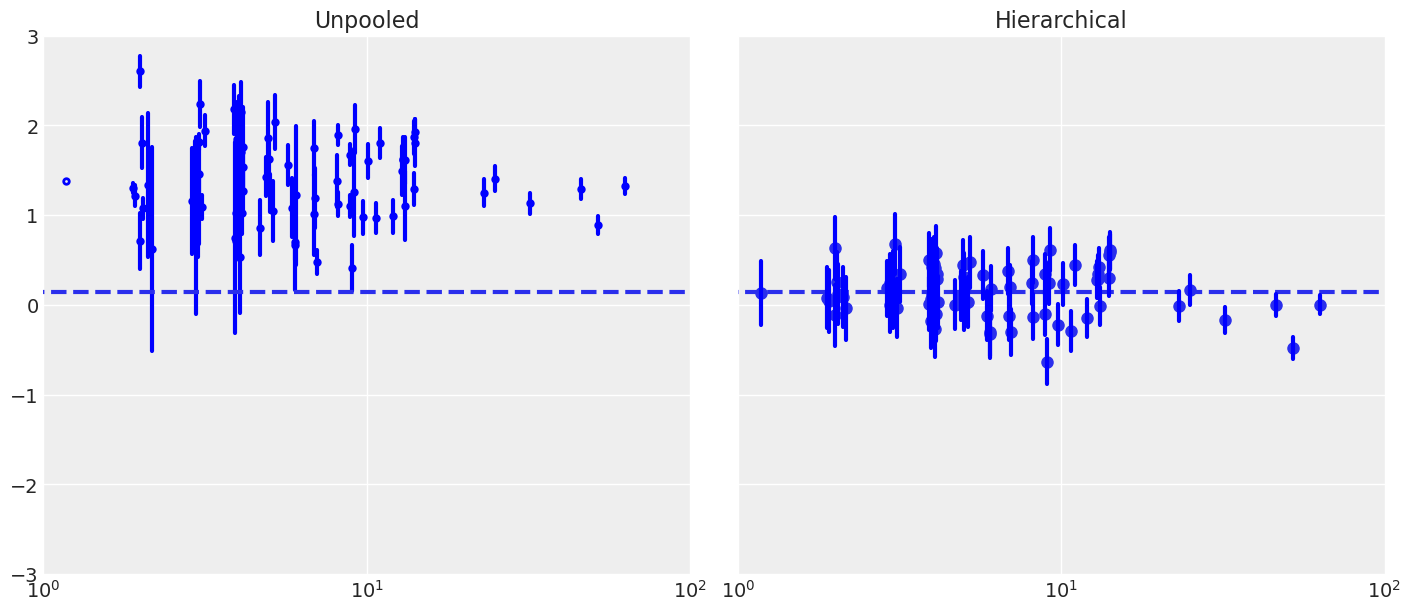

In [54]:
#the code below shows the amount of shrinkage (i.e, how much the unpooled estimate is pulled towards the global mean (pooled estimated)), 
# as a function of n_j, the number of observations available for each county.
sample_trace = hier_trace['alpha']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
n_samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties)

n_county = radon_data.groupby('county')['county_code'].count()
unpooled_means = radon_data.groupby('county')['log_radon'].mean()
unpooled_sd = radon_data.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[0].set_title("Unpooled")
        
n_samples, n_counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(-3, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
axes[1].set_title("Hierarchical")
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');
    
plt.savefig('img/shrinkage.png')


<img src='img/shrinkage.png' width=900 align="center" >

* For small sample sizes the estimates of the unpooled model are both more extreme and more uncertain compared to the hierarchical model.


* The estimates of the hierarchical model are smoothed towards the mean of the population and less uncertain.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [55]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,-1220.295747,49.128862,0.000000,9.254054e-01,27.995893,0.000000,True,log
unpooled,1,-1242.189209,82.907711,21.893462,7.264250e-16,28.408488,6.119778,True,log
pooled,2,-1273.566784,3.847803,53.271037,7.459456e-02,25.051897,10.727313,False,log


# Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group



# Prediction for an already observed county

* For example, we want to make a prediction for the first floor of a new house  in St. Louis county, which is county # 69.

For each sample $s$ in the posterior we simulate a value for log-radon in St. Louis as follows

$$\tilde{y}_{s,69} \sim N(\alpha_{s,69} + \beta_s x \sigma_{y,s})$$,

where $x$ represents the first floor.


# Prediction for a  county never observed 

* We want to make a prediction for a county which has never been observed before.
This requires two steps of sampling:

First we sample many intercepts from the population of intercepts; then we simulate many log-radon values.

$$\tilde{\alpha}_{s} \sim N(\mu_{\alpha,s},  \sigma_{\alpha,s})$$
$$\tilde{y}_s \sim N(\alpha_{s} + \beta \cdot (x=1), \sigma_y)$$


# Exercise

With the previous hierarchial  model:
 * make a prediction for the basement of a new hourse in county 69 
 * make a prediction for the basement of a house located in county for which there are not yet observations

# Your turn: Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

* Implement both models and discuss the result.

In [ ]:
# Write your answer here

---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.


Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.